## Surprise: precision weighted prediction error

In [25]:
# %%
%cd ~/work/free-energy-minimization-framework/11/
%load_ext autoreload
%autoreload 2

# %%
import torch
from torch import nn
import pdb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

from scipy.stats import norm

def normal_distribution(n, mean, var=0.05):
  x = norm.pdf(np.arange(0, 1, 1.0 / n), mean, var)
  x = x / np.sum(x)
  return torch.tensor(x).float()

def bhattacharya_distance(hist1,  hist2):
  hist1[hist1<0] = 0
  hist2[hist2<0] = 0

  a = 1 / (np.sum(hist1, axis=1) * np.sum(hist2, axis=1))
  b = np.sum(np.sqrt(hist1 * hist2), axis=1)
  return np.sqrt(1-a*b)

def imshow(title, image):
  plt.figure(figsize=figsize)
  plt.title(title)
  plt.imshow(image, cmap='gray')
  plt.show()

figsize=(15,5)
learning_rate = 0.01
quantization = 20

/Users/amolk/work/free-energy-minimization-framework/11
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training pattern: sin() with a bit of noise, normal distribution around mean

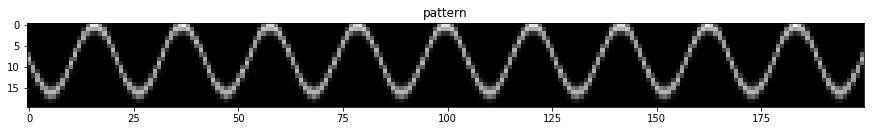

In [68]:
# %%
pattern_length = 200
pattern_floats = torch.tensor((np.sin(np.arange(pattern_length) * 0.30) + 1 + np.random.sample(int(pattern_length)) * 0.03) / 2.5).float()
pattern = torch.stack([normal_distribution(quantization, val) for val in pattern_floats])

imshow('pattern', pattern.t().numpy())

## Train an RNN to predict pattern

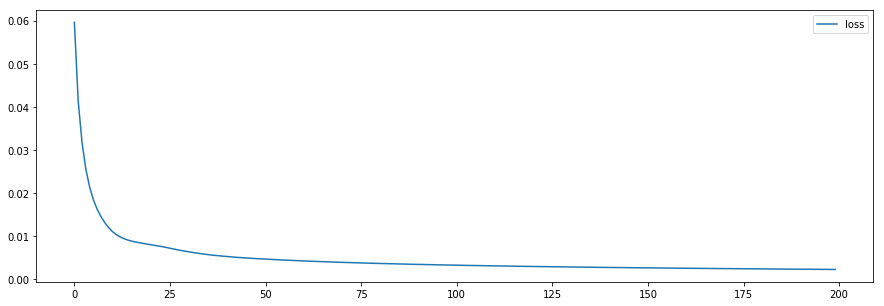

In [82]:
# %%
t_sample = 20
batch_size = pattern_length - t_sample - 1
input = torch.stack([pattern[i:i+t_sample] for i in np.arange(batch_size)])
target = torch.stack([pattern[i+1:i+t_sample+1] for i in np.arange(batch_size)])

hidden_size = t_sample

# %%
num_layers=1
rnn = nn.RNN (
  input_size=quantization,
  hidden_size=quantization,
  num_layers=num_layers,
  nonlinearity='tanh',
  batch_first=True
)

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
epoch = 0
losses = []
while epoch < 200:
  rnn.zero_grad()
  state = torch.zeros(num_layers, batch_size, quantization)
  out, state = rnn(input, state)
  # out = linear(out)
  # print('out', out)
  # print('state', state)
  loss = torch.nn.functional.mse_loss(out, target)
  loss.backward()
  optimizer.step()
  # print('loss', loss)
  losses.append(loss)
  epoch += 1

plt.figure(figsize=figsize)
plt.plot(losses, label='loss')
plt.legend()
plt.show()

## Test pattern (piecewise sin)

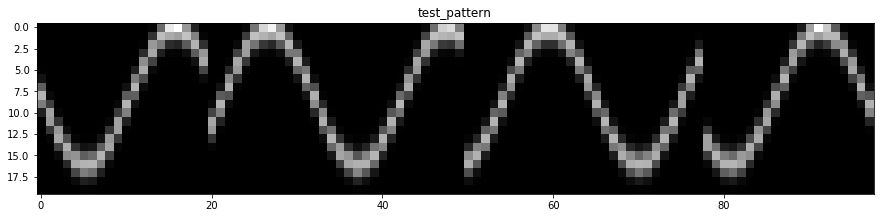

In [83]:
# %%
test_pattern = torch.cat([pattern[0:int(pattern_length*0.10)], pattern[int(pattern_length*0.15):int(pattern_length*0.30)], pattern[int(pattern_length*0.45):int(pattern_length*0.59)], pattern[int(pattern_length*0.85):int(pattern_length*0.95)]])
test_pattern_length = test_pattern.shape[0]
imshow('test_pattern', test_pattern.t())
test_batch_size = test_pattern_length - t_sample - 1
test_input = torch.stack([test_pattern[i:i+t_sample] for i in np.arange(test_batch_size)])
test_target = torch.stack([test_pattern[i+1:i+t_sample+1] for i in np.arange(test_batch_size)])

## Sample output of RNN

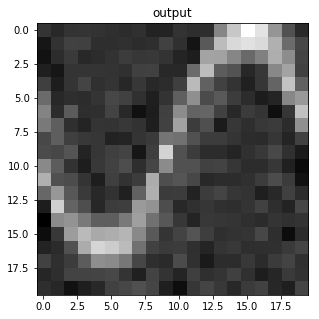

In [84]:
# %%
state = torch.zeros(num_layers, test_batch_size, quantization)
out, state = rnn(test_input, state)

imshow('output', out[0].detach().t())

## Predictions, precision weighting

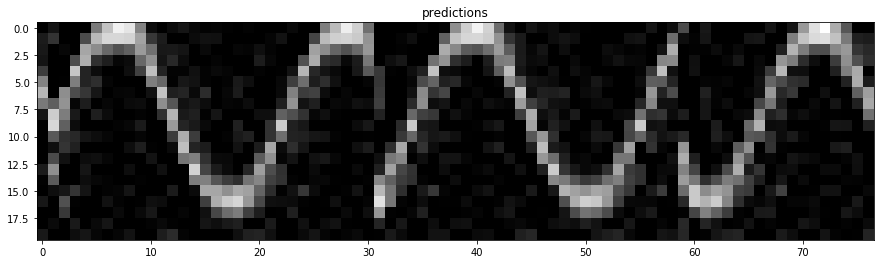

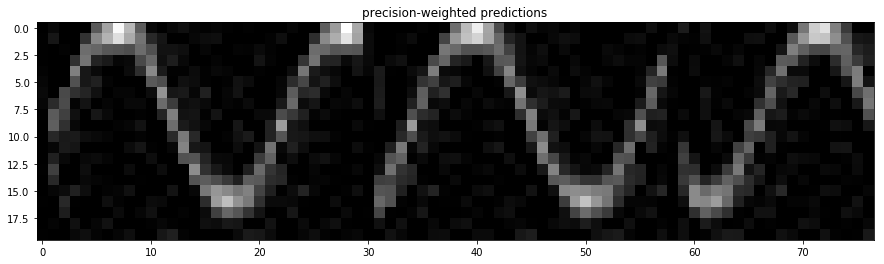

In [85]:
# last entry in out is the prediction
predictions = out[:, -1].detach()
predictions[predictions<0] = 0
imshow('predictions', predictions.t())

# %%
# prediction_var = np.var(predictions.numpy(), axis=1)
# prediction_precision = 1 / prediction_var

hist1 = np.asarray(predictions)
hist2 = np.asarray(test_target[:, -1, :])
distance = bhattacharya_distance(hist1, hist2)

precision_weighted_predictions = (1 - distance) * predictions.t().numpy()

imshow('precision-weighted predictions', precision_weighted_predictions)

Notice that precision weighting down-weighted predictions after breaks in the pattern due to low precision

## Precision-weighted error

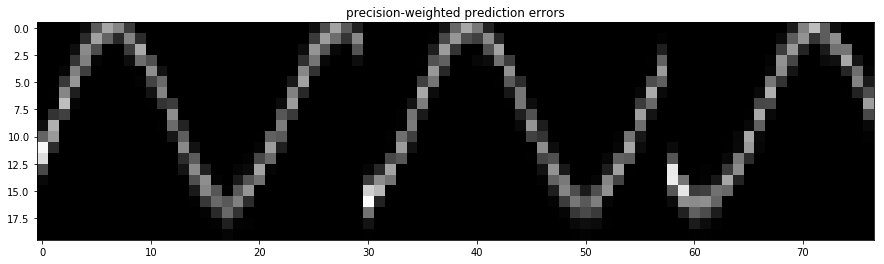

In [86]:
# %%
errors = test_target[:, -1, :].t().numpy() - precision_weighted_predictions
errors[errors<0] = 0
imshow('precision-weighted prediction errors', errors)
# %%

Note that high intensity of error signal coincides with low prediction precision/confidence.